In [2]:
import pathlib

import numpy as np
import scipy
import matplotlib.pyplot as plt
import polars as pl


In [3]:
def load_from_mat(
    file_path: str, start_time: float = 0, end_time: float = float("inf")
) -> pl.DataFrame:
    mat = scipy.io.loadmat(file_path)
    ts = mat["ans"]

    df = pl.DataFrame(
        {
            "time": ts[0, :],
            "travel": ts[1, :],
            "travel_rate": ts[2, :],
            "pitch": ts[3, :],
            "pitch_rate": ts[4, :],
            "elevation": ts[5, :],
            "elevation_rate": ts[6, :],
            "joystick_x": ts[7, :],
            "joystick_y": ts[8, :],
            "imu_pitch": ts[9, :],
            "imu_pitch_rate": ts[10, :],
            "imu_elevation": ts[11, :],
            "imu_elevation_rate": ts[12, :],
            "imu_travel": ts[13, :],
            "est_travel_rate": ts[14, :],
            "est_pitch": ts[15, :],
            "est_pitch_rate": ts[16, :],
            "est_elevation": ts[17, :],
            "est_elevation_rate": ts[18, :],
        }
    )

    df = df.with_columns(
        pl.when((pl.col("time") >= 10) & (pl.col("time") <= 11))
        .then(1)
        .otherwise(0)
        .alias("disturbance"),
        pl.col("elevation_rate").rolling_mean(window_size=75).alias("elevation_roll"),
    )

    return df.filter((pl.col("time") >= start_time) & (pl.col("time") <= end_time))


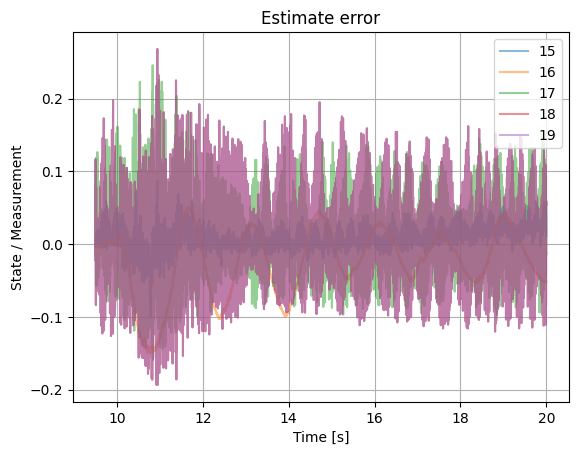

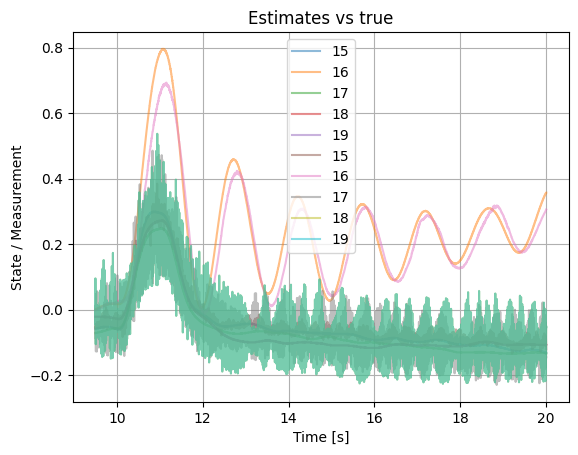

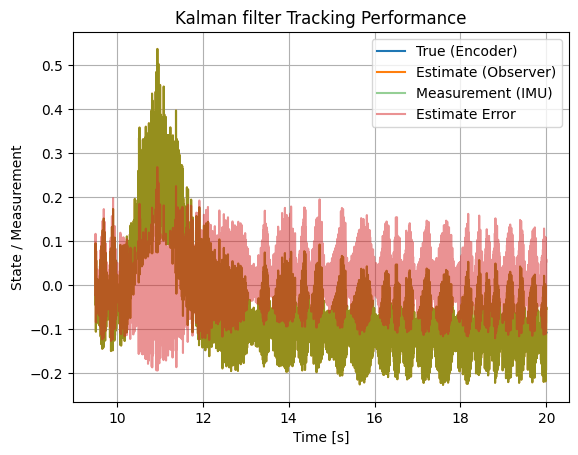

In [4]:
start_time = 9.5
end_time = 20

filename = "data/4_kalman/{}.mat"

data_15 = load_from_mat(filename.format(15), start_time, end_time)
data_16 = load_from_mat(filename.format(16), start_time, end_time)
data_17 = load_from_mat(filename.format(17), start_time, end_time)
data_18 = load_from_mat(filename.format(18), start_time, end_time)
data_19 = load_from_mat(filename.format(18), start_time, end_time)


plt.figure()
plt.plot(
    data_15["time"], data_15["est_pitch"] - data_15["pitch"], label="15", alpha=0.5
)
plt.plot(
    data_16["time"], data_16["est_pitch"] - data_16["pitch"], label="16", alpha=0.5
)
plt.plot(
    data_17["time"], data_17["est_pitch"] - data_17["pitch"], label="17", alpha=0.5
)
plt.plot(
    data_18["time"], data_18["est_pitch"] - data_18["pitch"], label="18", alpha=0.5
)
plt.plot(
    data_19["time"], data_18["est_pitch"] - data_18["pitch"], label="19", alpha=0.5
)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Estimate error")
plt.show()


plt.figure()
plt.plot(data_15["time"], data_15["pitch"], label="15", alpha=0.5)
plt.plot(data_16["time"], data_16["pitch"], label="16", alpha=0.5)
plt.plot(data_17["time"], data_17["pitch"], label="17", alpha=0.5)
plt.plot(data_18["time"], data_18["pitch"], label="18", alpha=0.5)
plt.plot(data_19["time"], data_19["pitch"], label="19", alpha=0.5)
plt.plot(data_15["time"], data_15["est_pitch"], label="15", alpha=0.5)
plt.plot(data_16["time"], data_16["est_pitch"], label="16", alpha=0.5)
plt.plot(data_17["time"], data_17["est_pitch"], label="17", alpha=0.5)
plt.plot(data_18["time"], data_18["est_pitch"], label="18", alpha=0.5)
plt.plot(data_19["time"], data_19["est_pitch"], label="19", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Estimates vs true")
plt.show()


plt.figure()
data = data_19
plt.plot(data["time"], data["pitch"], label="True (Encoder)")
plt.plot(data["time"], data["est_pitch"], label="Estimate (Observer)")
plt.plot(data["time"], data["imu_pitch"], label="Measurement (IMU)", alpha=0.5)
plt.plot(
    data["time"],
    data["est_pitch"] - data["pitch"],
    label="Estimate Error",
    alpha=0.5,
)
plt.xlabel("Time [s]")
plt.ylabel("State / Measurement")
plt.grid(True)
plt.legend()
plt.title("Kalman filter Tracking Performance")
plt.show()

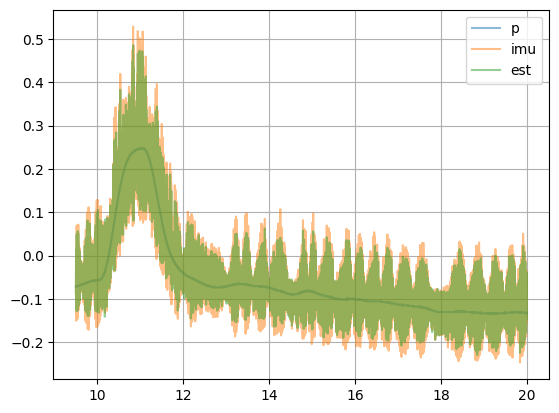

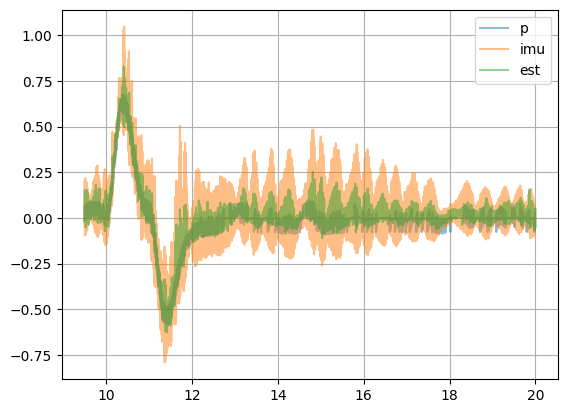

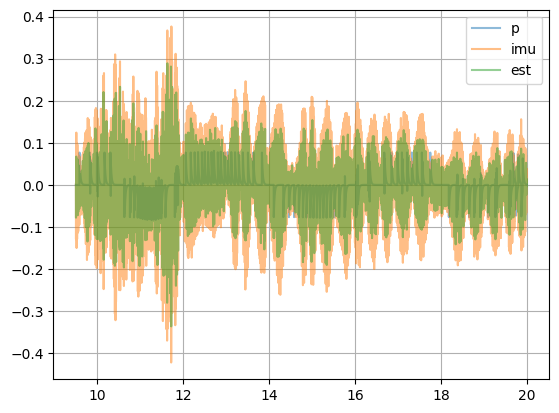

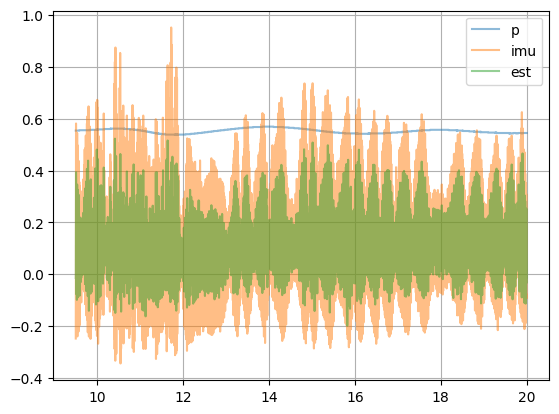

In [5]:
plt.figure()
data = data_17
plt.plot(data["time"], data["pitch"], label="p", alpha=0.5)
plt.plot(data["time"], data["imu_pitch"], label="imu", alpha=0.5)
plt.plot(data["time"], data["est_pitch"], label="est", alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
data = data_17
plt.plot(data["time"], data["pitch_rate"], label="p", alpha=0.5)
plt.plot(data["time"], data["imu_pitch_rate"], label="imu", alpha=0.5)
plt.plot(data["time"], data["est_pitch_rate"], label="est", alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
data = data_17
plt.plot(data["time"], data["elevation_rate"], label="p", alpha=0.5)
plt.plot(data["time"], data["imu_elevation_rate"], label="imu", alpha=0.5)
plt.plot(data["time"], data["est_elevation_rate"], label="est", alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
data = data_17
plt.plot(data["time"], data["elevation"], label="p", alpha=0.5)
plt.plot(data["time"], data["imu_elevation"], label="imu", alpha=0.5)
plt.plot(data["time"], data["est_elevation"], label="est", alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

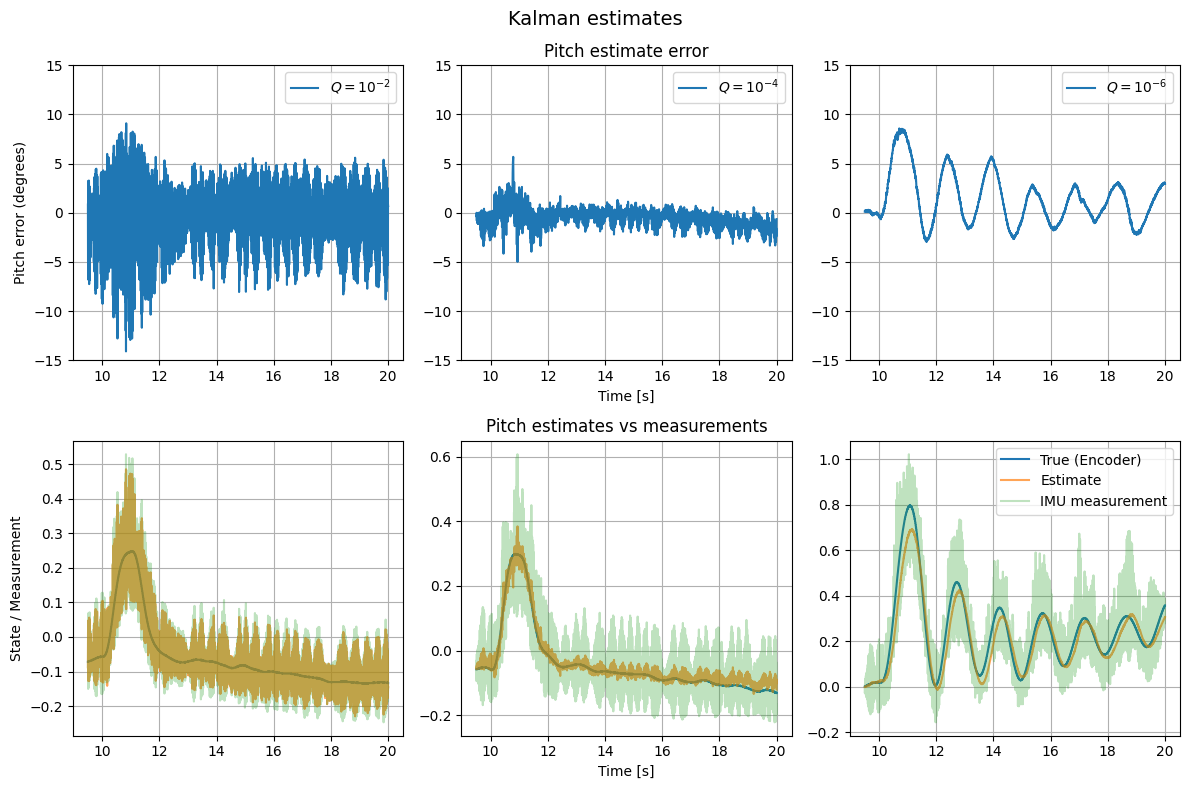

In [43]:
rtd = 180 / np.pi

fig, ((ax1, ax2, ax3), (bx1, bx2, bx3)) = plt.subplots(2, 3, figsize=(12, 8))

ax1.plot(
    data_17["time"],
    (data_17["pitch"] - data_17["est_pitch"]) * rtd,
    label=r"$Q = 10^{-2}$",
)
ax1.set_ylabel("Pitch error (degrees)")
ax1.set_ylim([-15, 15])
ax1.legend()
ax1.grid(True)

ax2.plot(
    data_15["time"],
    (data_15["pitch"] - data_15["est_pitch"]) * rtd,
    label=r"$Q = 10^{-4}$",
)
ax2.set_xlabel("Time [s]")
ax2.set_title("Pitch estimate error")
ax2.set_ylim([-15, 15])
ax2.legend()
ax2.grid(True)

ax3.plot(
    data_16["time"],
    (data_16["pitch"] - data_16["est_pitch"]) * rtd,
    label=r"$Q = 10^{-6}$",
)
ax3.set_ylim([-15, 15])
ax3.legend()
ax3.grid(True)

bx1.plot(data_17["time"], data_17["pitch"], label="True (Encoder)")
bx1.plot(data_17["time"], data_17["est_pitch"], label="Estimate", alpha=0.7)
bx1.plot(data_17["time"], data_17["imu_pitch"], label="IMU measurement", alpha=0.3)
bx1.set_ylabel("State / Measurement")
bx1.grid(True)

bx2.plot(data_15["time"], data_15["pitch"], label="True (Encoder)")
bx2.plot(data_15["time"], data_15["est_pitch"], label="Estimate", alpha=0.7)
bx2.plot(data_15["time"], data_15["imu_pitch"], label="IMU measurement", alpha=0.3)
bx2.set_xlabel("Time [s]")
bx2.grid(True)
bx2.set_title("Pitch estimates vs measurements")

bx3.plot(data_16["time"], data_16["pitch"], label="True (Encoder)")
bx3.plot(data_16["time"], data_16["est_pitch"], label="Estimate", alpha=0.7)
bx3.plot(data_16["time"], data_16["imu_pitch"], label="IMU measurement", alpha=0.3)
bx3.grid(True)
bx3.legend()

plt.suptitle("Kalman estimates", fontsize=14)
plt.tight_layout()
plt.show()